In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoderSequenceZ
from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2
from PFNExperiments.LatentFactorModels.Training.TrainerCurriculumCNF_LatentFactor import TrainerCurriculumCNF_LatentFactor
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LatentFactorModels.ComparisonModels.Hamiltionian_MC_Numpyro import Hamiltionian_MC
from PFNExperiments.Evaluation.Evaluate import Evaluate, results_dict_to_data_x_tuple, result_dict_to_latent_variable_convert_mu_sigma_to_beta, results_dict_to_data_x_tuple_transpose, result_dict_to_latent_variable_convert_phi_to_beta_flatten, just_return_results_flatten_beta

In [3]:
from PFNExperiments.LatentFactorModels.GenerativeModels.Numpyro_Versions.LDA_NumPyro import make_lda_program, make_lda_program_batched

from PFNExperiments.LatentFactorModels.ComparisonModels.MakeDefaultListComparison import make_default_list_comparison, make_reduced_list_comparison


In [4]:
N = 50
P = 5
K = 3
BATCH_SIZE = 32
N_EPOCHS = 1
N_SAMPLES_PER_EPOCH = 1000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE

In [5]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list([
    ("n_docs", curriculum.constant_scheduler(N)),
    ("n_words", curriculum.constant_scheduler(P)),
    ("n_topics", curriculum.constant_scheduler(K)),
    ("batch_size", curriculum.constant_scheduler(BATCH_SIZE)),
    ("alpha_dir", curriculum.constant_scheduler(0.1)),
    ("beta_dir", curriculum.constant_scheduler(0.1)),
    ("doc_len_max", curriculum.constant_scheduler(100)),
    ("doc_len_mean", curriculum.constant_scheduler(10.0))
])
#curriculum.plot_all_schedules()

In [6]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_lda_program_batched,
    curriculum= curriculum,
)

pprogram_covariates_train is None, using pprogram_covariates instead
pprogram_covariates_val is None, using pprogram_covariates instead
pprogram_covariates_test is None, using pprogram_covariates instead


In [7]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 1001
    )

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 992 and 496 respectively


In [8]:
sample_batch = next(iter(epoch_loader[0][0]))

In [9]:
for key, value in sample_batch.items():
    print(key, value.shape)

theta torch.Size([32, 50, 3])
phi torch.Size([32, 3, 5])
x torch.Size([32, 50, 5])
beta torch.Size([32, 3, 5])
time torch.Size([32])
base_sample_beta torch.Size([32, 3, 5])


In [10]:
"""
data_generator.check_model(
    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,
    epochs_to_check = [0, N_EPOCHS-1],
    p = P,
    n = N,
    used_batch_samples = 1,
    batch_size= BATCH_SIZE,
)
"""

'\ndata_generator.check_model(\n    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,\n    epochs_to_check = [0, N_EPOCHS-1],\n    p = P,\n    n = N,\n    used_batch_samples = 1,\n    batch_size= BATCH_SIZE,\n)\n'

In [11]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 1000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 992 and 496 respectively


In [12]:
sample_batch = next(iter(epoch_loader[0][0]))
sample_batch.keys()

dict_keys(['theta', 'phi', 'x', 'beta', 'time', 'base_sample_beta'])

In [13]:
sample_batch["x"].shape, sample_batch["beta"].shape

(torch.Size([32, 50, 5]), torch.Size([32, 3, 5]))

In [27]:
"""
model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = 1,
    n_input_features_decoder = 2*P,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)
"""

model = TransformerCNFConditionalDecoderSequenceZ(
    n_input_features_encoder = P,
    n_input_features_decoder = P,
    d_model_encoder = 16,
    d_model_decoder = 16,
    n_heads_encoder = 1,
    n_heads_decoder = 1,
    d_ff_encoder = 16,
    d_ff_decoder = 16,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 16,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = True,
    use_self_attention_decoder = True,
    output_dim = P,

)

In [28]:
loss_fun = CFMLossOT2(
    sigma_min=1e-4
)

In [29]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(opt,
                       max_lr = 5e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e4)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}



In [30]:
trainer = TrainerCurriculumCNF_LatentFactor(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = None,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0,
    

)

In [31]:
K, P

(3, 5)

In [32]:
trainer.validate()

 50%|█████     | 2/4 [00:15<00:13,  6.55s/it]

x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])


100%|██████████| 4/4 [00:15<00:00,  4.00s/it]

torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([3, 50, 16])
condition: torch.Size([3, 16])
x_decoder: torch.Size([3, 3, 5])
torch.Size([3, 3, 16])

              vector_field_prediction: torch.Size([3, 3, 5])
              target: torch.Size([3, 3, 5])
              


{'loss_mean': 1.2756271362304688,
 'loss_median': 1.2361645698547363,
 'loss_std': 0.10996703803539276}

In [33]:
r = trainer.train()

Curriculum parameters: {'n_docs': 50, 'n_words': 5, 'n_topics': 3, 'batch_size': 32, 'alpha_dir': 0.1, 'beta_dir': 0.1, 'doc_len_max': 100, 'doc_len_mean': 10.0} at iteration 0


  6%|▋         | 1/16 [00:11<02:54, 11.64s/it]

x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              


 19%|█▉        | 3/16 [00:12<00:36,  2.77s/it]

x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])


 25%|██▌       | 4/16 [00:12<00:21,  1.78s/it]

torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              


 31%|███▏      | 5/16 [00:12<00:13,  1.21s/it]

x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])


 38%|███▊      | 6/16 [00:12<00:08,  1.15it/s]

torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              


 44%|████▍     | 7/16 [00:13<00:06,  1.48it/s]

x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])


 50%|█████     | 8/16 [00:13<00:04,  1.90it/s]

torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              


 62%|██████▎   | 10/16 [00:13<00:02,  2.83it/s]

x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              


 75%|███████▌  | 12/16 [00:14<00:01,  3.35it/s]

x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])


 81%|████████▏ | 13/16 [00:14<00:00,  3.73it/s]

torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              


 94%|█████████▍| 15/16 [00:14<00:00,  4.38it/s]

x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([16, 50, 16])
condition: torch.Size([16, 16])
x_decoder: torch.Size([16, 3, 5])
torch.Size([16, 3, 16])

              vector_field_prediction: torch.Size([16, 3, 5])
              target: torch.Size([16, 3, 5])
              


 75%|███████▌  | 3/4 [00:00<00:00, 12.25it/s]

x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              
x_encoder: torch.Size([32, 50, 16])
condition: torch.Size([32, 16])
x_decoder: torch.Size([32, 3, 5])
torch.Size([32, 3, 16])

              vector_field_prediction: torch.Size([32, 3, 5])
              target: torch.Size([32, 3, 5])
              


100%|██████████| 4/4 [00:00<00:00, 13.17it/s]


x_encoder: torch.Size([3, 50, 16])
condition: torch.Size([3, 16])
x_decoder: torch.Size([3, 3, 5])
torch.Size([3, 3, 16])

              vector_field_prediction: torch.Size([3, 3, 5])
              target: torch.Size([3, 3, 5])
              


  0%|          | 0/4 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [59]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (K,P),
    n_samples=100,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 1000,
    rtol = 1000,
    #device = torch.device("cpu")
)

benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
del benchmark_params_ppgrogram["batch_size"]
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_lda_program(**benchmark_params_ppgrogram)

pprogram1_x = pprogram1



params for pprogram: {'n_docs': 50, 'n_words': 5, 'n_topics': 3, 'alpha_dir': 0.1, 'beta_dir': 0.1, 'doc_len_max': 100, 'doc_len_mean': 10.0}


In [60]:
test_batch = next(iter(epoch_loader[0][1]))
x_test = test_batch["x"]

In [61]:
x_test.shape

torch.Size([32, 50, 5])

In [62]:
samples = full_model.sample_posterior(x_test[0])

100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


In [63]:
samples["beta"].shape

torch.Size([100, 3, 5])

In [64]:
hmc = Hamiltionian_MC(
    pprogram=pprogram1_x,
    n_samples=100,
    n_warmup=100
)

models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 500)

In [67]:
"""
evaluation = Evaluate(
    posterior_model = models[1],
    evaluation_loader = trainer.testset,
    comparison_models= [hmc],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_mu_sigma_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)
"""

evaluation = Evaluate(
    posterior_model = full_model,
    evaluation_loader = trainer.testset,
    comparison_models= [hmc],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_posterior_model = just_return_results_flatten_beta,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_phi_to_beta_flatten,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [68]:
evaluation.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LatentFactorModels\ComparisonModels\Hamiltionian_MC_Numpyro.py:65: FutureWarning: Some algorithms will automatically enumerate the discrete latent site doc_len of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  self.mcmc.run(rng_key=self.sample_key, x=x)
Sampling posterior:  50%|█████     | 1/2 [00:08<00:08,  8.73s/it]C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LatentFactorModels\ComparisonModels\Hamiltionian_MC_Numpyro.py:65: FutureWarning: Some algorithms will automatically enumerate the discrete latent site doc_len of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  self.mcmc.run(rng_key=self.sample_key, x=x)


torch.Size([100, 3, 5])


Sampling posterior: 100%|██████████| 2/2 [00:15<00:00,  7.67s/it]


torch.Size([100, 3, 5])


100%|██████████| 2/2 [00:00<00:00, 614.87it/s]


An exception occured in compare_to_gt_perplexity_kde: too many values to unpack (expected 2)
An exception occured in compare_to_gt_MAP: too many values to unpack (expected 2)
An exception occured in compare_to_gt_perplexity_kde: too many values to unpack (expected 2)
An exception occured in compare_to_gt_MAP: too many values to unpack (expected 2)


  0%|          | 0/100 [00:00<?, ?it/s]


model_latent_variable_sample: torch.Size([2, 3, 5])
gt_latent_variable: torch.Size([2, 3, 5])


RuntimeError: Tensors must have same number of dimensions: got 3 and 2

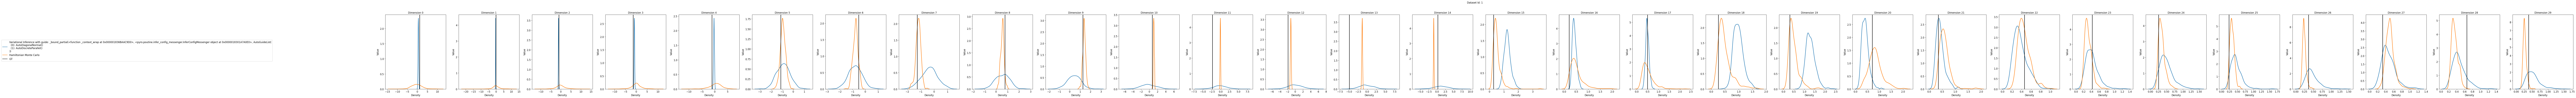

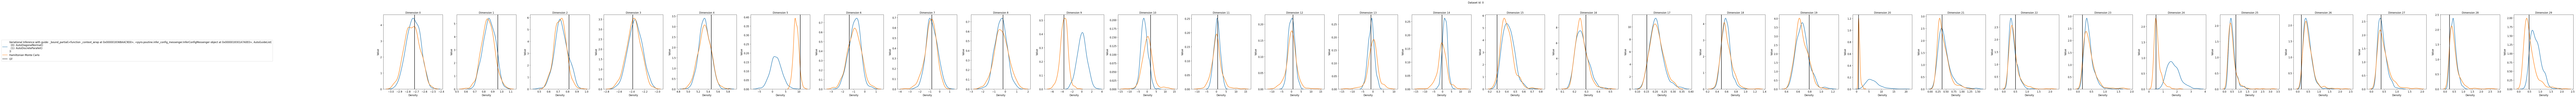

In [29]:
evaluation.plot_results()

In [30]:
from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor, PreprocessorClassification

In [31]:
from PFNExperiments.Evaluation.RealWorldEvaluation.Preprocess_multivariate_GMM import Preprocessor_GMM_multivariate
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML
getdata = GetDataOpenML(
    preprocessor = Preprocessor_GMM_multivariate(
        N_datapoints = N,
        P_features = P,
        x_mean = 0.0,
        x_var = 1.0,
    ),
    save_path = "C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/Evaluation/RealWorldEvaluation/DatasetsOpenML/Tabular_benchmark_numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

In [32]:
comparison_models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000)

In [33]:
from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld


eval = EvaluateRealWorld(
    
    posterior_model = full_model,
    evaluation_datasets = datasets,
    comparison_models = comparison_models[1:3],
    n_evaluation_cases = 2,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_mu_sigma_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple
)

In [34]:
eval.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

....................


Sampling posterior:  50%|█████     | 1/2 [01:05<01:05, 65.59s/it]

....................


Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

....................


Sampling posterior:  50%|█████     | 1/2 [01:11<01:11, 71.75s/it]

....................


Sampling posterior: 100%|██████████| 2/2 [02:21<00:00, 70.60s/it]


Comparison to ground truth:

Summarized results:

Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,6.898867,2.530607,1.0,0.073339,0.215496,0.0
1,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,6.972900,2.602366,1.0,0.091395,0.155081,0.0
2,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,6.791085,5.342443,1.0,0.161377,0.561083,0.0


P-values:


,Pair 1: Model A,Pair 1: Model B,Pair 2: Model A,Pair 2: Model B,Wasserstein_distance with metric euclidean_p-value,MMD_p-value,cst_roc_auc_p-value
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,0.698535,0.698535,1.0
1,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,0.698535,0.245278,1.0
2,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,0.245278,0.245278,1.0


{'summarized_results': {'model_comparison_among_each_other':                                              Model 1  \
  0  <PFNExperiments.LinearRegression.Models.ModelT...   
  1  <PFNExperiments.LinearRegression.Models.ModelT...   
  2  Variational Inference with guide: _bound_parti...   
  
                                               Model 2  \
  0  Variational Inference with guide: _bound_parti...   
  1  Variational Inference with guide: _bound_parti...   
  2  Variational Inference with guide: _bound_parti...   
  
     Mean_Wasserstein_distance with metric euclidean  Mean_MMD  \
  0                                         6.898867  2.530607   
  1                                         6.972900  2.602366   
  2                                         6.791085  5.342443   
  
     Mean_cst_roc_auc  Std_Wasserstein_distance with metric euclidean   Std_MMD  \
  0               1.0                                        0.073339  0.215496   
  1               1.0                 